Authors: Antoine A. Ruzette
Date: 2025-02-21

This notebook processes cell measurement tables exported from QuPath to plot the spatial distribution of cell-level pixel intensity in relation to a modelled stromal border. It also supports the comparison of confusion matrices between threshold- and machine learning-based cell classification.

Contains the code to plot data from images containing four channels: DAPI (nuclei), TRITC (cytokeratin), FITC (fibronectin) and CY5 (Ki67). 

In [4]:
import os
import pandas as pd
import numpy as np
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import natsort
import re
from matplotlib.ticker import LogFormatterSciNotation
from fitter import Fitter, get_common_distributions, get_distributions

# colorblind-friendly colors
CB_palette = ['#377eb8', '#ff7f00', '#4daf4a',
                '#f781bf', '#a65628', '#984ea3',
                '#999999', '#e41a1c', '#dede00']

## Back-end functions

In [5]:
def load_and_preprocess_files(folder_path, file_paths, expected_columns):
    """
    Load and preprocess CSV files.

    Args:
        folder_path (str): Path to the folder containing CSV files.
        file_paths (list): List of file names.
        expected_columns (dict): Dictionary mapping expected column keys to possible names.

    Returns:
        list: A list of processed DataFrames (one per image).
        dict: Column mapping for use in plotting.
    """
    dfs = []
    final_column_mapping = {}

    for image in file_paths:
        print(f"\n🔹 Processing: {image}")
        file_path = os.path.join(folder_path, image)

        # Load CSV to check available columns first
        try:
            df_sample = pd.read_csv(file_path, nrows=1)
            available_columns = df_sample.columns.tolist()
            print(f"✅ Available Columns: {available_columns}")
        except Exception as e:
            print(f"❌ Error loading {image}: {e}")
            continue

        # Dynamically map expected column names to available ones
        column_mapping = {}
        for key, possible_names in expected_columns.items():
            for name in possible_names:
                if name in available_columns:
                    column_mapping[key] = name
                    break
            else:
                print(f"⚠️ Warning: {key} column not found in {image}. Skipping.")

        if not column_mapping:
            print(f"⚠️ Skipping {image} as no expected columns were found.")
            continue

        # Reload dataframe with only found columns
        try:
            df = pd.read_csv(file_path, usecols=list(column_mapping.values()))
        except Exception as e:
            print(f"❌ Error loading selected columns in {image}: {e}")
            continue

        # Skip this file if essential columns are missing
        essential_columns = ["DAPI", "pNDRG1_647"]
        missing_essential = [col for col in essential_columns if col not in column_mapping]
        if missing_essential:
            print(f"⚠️ Skipping {image} due to missing essential columns: {missing_essential}")
            continue

        # Remove outliers dynamically (only for present columns)
        outlier_limits = {}
        for key in ["DAPI", "pNDRG1_647", "KER_488", "FN_568"]:
            if key in column_mapping:
                col_name = column_mapping[key]
                p01 = df[col_name].quantile(0.01)
                p99 = df[col_name].quantile(0.99)
                outlier_limits[col_name] = (p01, p99)

        print(f"📊 Outlier Thresholds: {outlier_limits}")

        # Filter outliers
        df_no_outlier = df.copy()
        for col, (p01, p99) in outlier_limits.items():
            df_no_outlier = df_no_outlier[(df_no_outlier[col] >= p01) & (df_no_outlier[col] <= p99)]

        if df_no_outlier.empty:
            print(f"⚠️ Skipping {image} as it became empty after outlier removal.")
            continue

        # ✅ Store actual filename instead of "1G", "2G" etc.
        df_no_outlier["Image"] = os.path.splitext(os.path.basename(image))[0]

        dfs.append(df_no_outlier)

        # Save column mapping for later use
        final_column_mapping = column_mapping  

    if dfs:
        return dfs, final_column_mapping
    else:
        print("⚠️ No valid data loaded.")
        return [], {}


# Confusion matrix to compare ML vs threshold-based classification

## Check if datasets have same length

In [6]:
expected_columns = {
    "Classification": ["Classification"],
    "Object ID": ["Object ID"],
    "DAPI": ["DAPI: Nucleus: Median"],
    "KER_488": ["KER_488: Cytoplasm: Median"],
    "pNDRG1_647": ["pNDRG1_647: Cell: Max"],
    "FN_568": ["FN_568: Cell: Median"]
    }

file_paths = [
    "all_measurements.csv"
]

folder_thr = "/Users/antoine/Harvard/IAC/image_analysis_paper_QP_projects/AsPC_NDRG1/results/thresholds/20250328_spatial_full"
folder_ML = "/Users/antoine/Harvard/IAC/image_analysis_paper_QP_projects/AsPC_NDRG1/results/ML/20250328_spatial_full"

thr_label, _ = load_and_preprocess_files(folder_thr, file_paths, expected_columns)
ML_all, _ = load_and_preprocess_files(folder_ML, file_paths, expected_columns)


# # Ensure that you are actually working with DataFrames
# if ML_all:
#     ML_all = ML_all[0]  # Take the first DataFrame if available
# else:
#     raise ValueError("No valid data was loaded for ML_all.")

# if thr_label:
#     thr_label = thr_label[0]  # Take the first DataFrame if available
# else:
#     raise ValueError("No valid data was loaded for thr_label.")

# Now safely perform set operations on 'Object ID'
common_object_ids = len(set(ML_all[0]['Object ID']).intersection(set(thr_label[0]['Object ID'])))
print("Number of common Object IDs between the two datasets:", common_object_ids)

flag = (len(set(ML_all[0]['Object ID'])) == len(set(thr_label[0]['Object ID'])))
print("Datasets have the same number of cells:", flag)

# # # Create a lookup table for class name conversion
# # class_lookup_ML = {
# #     'FITC KER: CY5 pNDRG1': 'pNDRG1+: KER+',
# #     'KER+: pNDRG1-': 'pNDRG1-: KER+',
# #     'KER-: pNDRG1-': 'pNDRG1-: KER-',
# #     'KER-: pNDRG1+': 'pNDRG1+: KER-',
# #     'pNDRG1+: KER+': 'pNDRG1+: KER+',
# #     'pNDRG1+: KER-': 'pNDRG1+: KER-',
# #     'pNDRG1-: KER+': 'pNDRG1-: KER+',
# #     'pNDRG1-: KER-': 'pNDRG1-: KER-'
# # }

# # Apply the lookup table to the 'Classification' column in all_thr
# # ML_all['Classification'] = ML_all['Classification'].map(class_lookup_ML)

# Create a lookup table for class name conversion
class_lookup = {
    'FITC KER: CY5 pNDRG1': 'pNDRG1+: KER+',
    'FITC KER': 'pNDRG1-: KER+',
    'CY5 pNDRG1': 'pNDRG1+: KER-',
    # Add more mappings as needed
    np.nan: 'pNDRG1-: KER-'  # Represent NaN as a class itself
}


# Apply the lookup table to both datasets
# ML_all[0]['Classification'] = ML_all[0]['Classification'].map(class_lookup)
thr_label[0]['Classification'] = thr_label[0]['Classification'].map(class_lookup)

# # Print class distributions to verify
print("Updated Thresholds dataset classifications:")
print(thr_label[0]['Classification'].value_counts())

print("\nUpdated ML dataset classifications:")
print(ML_all[0]['Classification'].value_counts())

thr_label = thr_label[0]
ML_all = ML_all[0]


🔹 Processing: all_measurements.csv
✅ Available Columns: ['Image', 'Object ID', 'Object type', 'Name', 'Classification', 'Parent', 'ROI', 'Centroid X µm', 'Centroid Y µm', 'Detection probability', 'Nucleus: Area µm^2', 'Nucleus: Length µm', 'Nucleus: Circularity', 'Nucleus: Solidity', 'Nucleus: Max diameter µm', 'Nucleus: Min diameter µm', 'Cell: Area µm^2', 'Cell: Length µm', 'Cell: Circularity', 'Cell: Solidity', 'Cell: Max diameter µm', 'Cell: Min diameter µm', 'Nucleus/Cell area ratio', 'DAPI: Nucleus: Mean', 'DAPI: Nucleus: Median', 'DAPI: Nucleus: Min', 'DAPI: Nucleus: Max', 'DAPI: Nucleus: Std.Dev.', 'DAPI: Cytoplasm: Mean', 'DAPI: Cytoplasm: Median', 'DAPI: Cytoplasm: Min', 'DAPI: Cytoplasm: Max', 'DAPI: Cytoplasm: Std.Dev.', 'DAPI: Membrane: Mean', 'DAPI: Membrane: Median', 'DAPI: Membrane: Min', 'DAPI: Membrane: Max', 'DAPI: Membrane: Std.Dev.', 'DAPI: Cell: Mean', 'DAPI: Cell: Median', 'DAPI: Cell: Min', 'DAPI: Cell: Max', 'DAPI: Cell: Std.Dev.', 'KER_488: Nucleus: Mean', 'K

Thresholds dataset classifications:
Classification
pNDRG1+: KER+    312240
pNDRG1-: KER+    133145
pNDRG1-: KER-      8599
pNDRG1+: KER-      5165
Name: count, dtype: int64

ML dataset classifications:
Classification
pNDRG1+: KER+    262018
pNDRG1-: KER+    184543
pNDRG1-: KER-      9963
pNDRG1+: KER-      2625
Name: count, dtype: int64
True Class: pNDRG1+: KER+
Predicted Class: pNDRG1+: KER+, Count: 257420
Predicted Class: pNDRG1-: KER+, Count: 1933
Predicted Class: pNDRG1+: KER-, Count: 2658
Predicted Class: pNDRG1-: KER-, Count: 7

True Class: pNDRG1-: KER+
Predicted Class: pNDRG1+: KER+, Count: 52193
Predicted Class: pNDRG1-: KER+, Count: 127554
Predicted Class: pNDRG1+: KER-, Count: 858
Predicted Class: pNDRG1-: KER-, Count: 3938

True Class: pNDRG1+: KER-
Predicted Class: pNDRG1+: KER+, Count: 1556
Predicted Class: pNDRG1-: KER+, Count: 64
Predicted Class: pNDRG1+: KER-, Count: 976
Predicted Class: pNDRG1-: KER-, Count: 29

True Class: pNDRG1-: KER-
Predicted Class: pNDRG1+: KER+

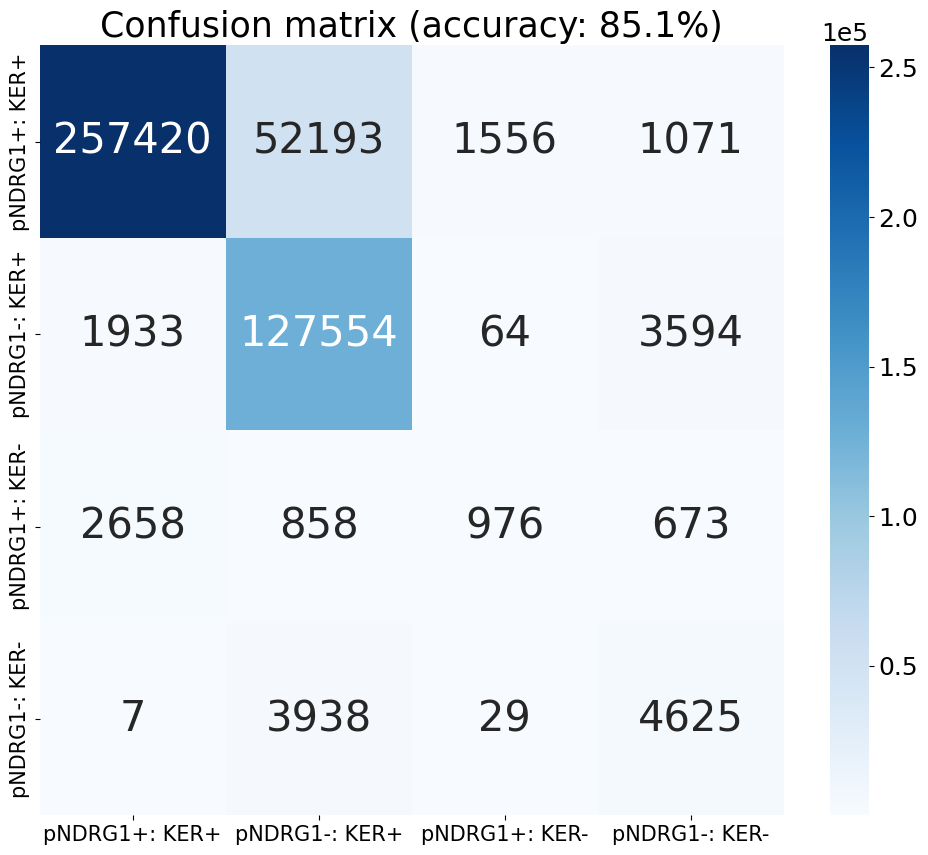

In [7]:
print("Thresholds dataset classifications:")
print(thr_label['Classification'].value_counts())

print("\nML dataset classifications:")
print(ML_all['Classification'].value_counts())

# Merge the datasets on the 'Object ID' column
merged_data = pd.merge(ML_all, thr_label, on='Object ID', suffixes=('_ML', '_Thr'))

# Get common 'Object ID' cells between the two datasets
common_object_ids = set(ML_all['Object ID']).intersection(set(thr_label['Object ID']))

# Filter the merged data to include only common 'Object ID' cells
merged_data_common = merged_data[merged_data['Object ID'].isin(common_object_ids)]

# Initialize counts for each class combination
class_counts = {
    'pNDRG1+: KER+': {'pNDRG1+: KER+': 0, 'pNDRG1-: KER+': 0, 'pNDRG1+: KER-': 0, 'pNDRG1-: KER-': 0},
    'pNDRG1-: KER+': {'pNDRG1+: KER+': 0, 'pNDRG1-: KER+': 0, 'pNDRG1+: KER-': 0, 'pNDRG1-: KER-': 0},
    'pNDRG1+: KER-': {'pNDRG1+: KER+': 0, 'pNDRG1-: KER+': 0, 'pNDRG1+: KER-': 0, 'pNDRG1-: KER-': 0},
    'pNDRG1-: KER-': {'pNDRG1+: KER+': 0, 'pNDRG1-: KER+': 0, 'pNDRG1+: KER-': 0, 'pNDRG1-: KER-': 0}
}

# Iterate through the merged data and count occurrences of each class combination
for _, row in merged_data_common.iterrows():
    class_counts[row['Classification_ML']][row['Classification_Thr']] += 1

# Print the class counts
for true_class, predicted_classes in class_counts.items():
    print(f'True Class: {true_class}')
    for predicted_class, count in predicted_classes.items():
        print(f'Predicted Class: {predicted_class}, Count: {count}')
    print()

# Define class labels
classes = ['pNDRG1+: KER+', 'pNDRG1-: KER+', 'pNDRG1+: KER-', 'pNDRG1-: KER-']
#classes = ['KER+: pNDRG1+', 'KER+: pNDRG1-', 'KER-: pNDRG1+', 'KER-: pNDRG1-']

# Create a DataFrame from class counts dictionary
confusion_df = pd.DataFrame(class_counts, index=classes)

# Sum up counts along the diagonal (correct predictions)
correct_predictions = np.diag(confusion_df)

# Total number of samples
total_samples = confusion_df.values.sum()

# Calculate ratio of agreement
agreement_ratio = (correct_predictions.sum() / total_samples) * 100

print("Ratio of agreement between the two methods:", agreement_ratio)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
ax = sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 30})
plt.title(f'Confusion matrix (accuracy: {agreement_ratio:.1f}%)', fontsize=25)
# plt.ylabel('Threshold-based classification', fontsize=18)
# plt.xlabel('ML-based classification', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=15)
# Set scientific notation for the colorbar
cbar = ax.collections[0].colorbar
cbar.ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
cbar.ax.tick_params(labelsize=18)  # Set colorbar tick labels font size

# Increase font size of the exponent (scientific notation) above the colorbar
if cbar.ax.yaxis.get_offset_text():  # Check if offset text exists
    cbar.ax.yaxis.get_offset_text().set_size(18)  # Set its font size

plt.savefig("/Users/antoine/Harvard/IAC/image_analysis_paper_QP_projects/AsPC_NDRG1/plots/confusion_matrix/supp_pNDRG1_confusion_matrix.png", dpi=300)
plt.show()

True Class: pNDRG1+: KER+
Predicted Class: pNDRG1+: KER+, Count: 257420
Predicted Class: pNDRG1-: KER+, Count: 1933

True Class: pNDRG1-: KER+
Predicted Class: pNDRG1+: KER+, Count: 52193
Predicted Class: pNDRG1-: KER+, Count: 127554



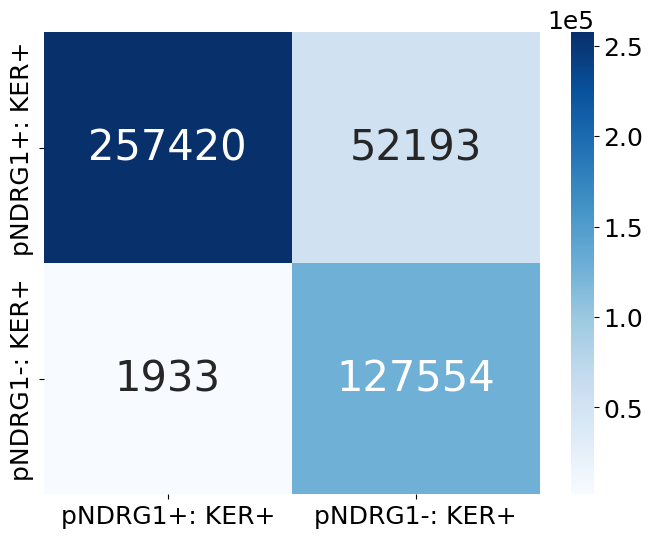

In [10]:
all_thr_subset = thr_label[thr_label['Classification'].isin(['pNDRG1+: KER+', 'pNDRG1-: KER+'])]
all_ML_subset = ML_all[ML_all['Classification'].isin(['pNDRG1+: KER+', 'pNDRG1-: KER+'])]

# Merge the datasets on the 'Object ID' column
merged_data = pd.merge(all_ML_subset, all_thr_subset, on='Object ID', suffixes=('_ML', '_Thr'))

# Get common 'Object ID' cells between the two datasets
common_object_ids = set(all_ML_subset['Object ID']).intersection(set(all_thr_subset['Object ID']))

# Filter the merged data to include only common 'Object ID' cells
merged_data_common = merged_data[merged_data['Object ID'].isin(common_object_ids)]

# Initialize counts for each class combination
class_counts = {
    'pNDRG1+: KER+': {'pNDRG1+: KER+': 0, 'pNDRG1-: KER+': 0},
    'pNDRG1-: KER+': {'pNDRG1+: KER+': 0, 'pNDRG1-: KER+': 0},
}

# Iterate through the merged data and count occurrences of each class combination
for _, row in merged_data_common.iterrows():
    class_counts[row['Classification_ML']][row['Classification_Thr']] += 1

# Print the class counts
for true_class, predicted_classes in class_counts.items():
    print(f'True Class: {true_class}')
    for predicted_class, count in predicted_classes.items():
        print(f'Predicted Class: {predicted_class}, Count: {count}')
    print()

# Define class labels
classes = ['pNDRG1+: KER+', 'pNDRG1-: KER+']
#classes = ['KER+: pNDRG1+', 'KER+: pNDRG1-', 'KER-: pNDRG1+', 'KER-: pNDRG1-']

# Create a DataFrame from class counts dictionary
confusion_df = pd.DataFrame(class_counts, index=classes)

# Sum up counts along the diagonal (correct predictions)
correct_predictions = np.diag(confusion_df)

# Total number of samples
total_samples = confusion_df.values.sum()

# Calculate ratio of agreement
agreement_ratio = (correct_predictions.sum() / total_samples) * 100
# Plot confusion matrix
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 30})
# plt.title(f'Confusion matrix (accuracy: {agreement_ratio:.1f}%)', fontsize=13)
# plt.ylabel('Threshold-based classification', fontsize=18)
# plt.xlabel('ML-based classification', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
# Set scientific notation for the colorbar
cbar = ax.collections[0].colorbar
cbar.ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
cbar.ax.tick_params(labelsize=18)  # Set colorbar tick labels font size

# Increase font size of the exponent (scientific notation) above the colorbar
if cbar.ax.yaxis.get_offset_text():  # Check if offset text exists
    cbar.ax.yaxis.get_offset_text().set_size(18)  # Set its font size

plt.savefig("/Users/antoine/Harvard/IAC/image_analysis_paper_QP_projects/AsPC_NDRG1/plots/confusion_matrix/pNDRG1_confusion_matrix.png", dpi=300)
plt.show()